<a href="https://colab.research.google.com/github/alessandrossC/ML-for-people/blob/main/%22HW_2_5_Time_Series_Analysis_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

У цьому ДЗ ми попрактикуємось моделювати часові ряди на даних з [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). Ми будемо працювати лише з тренувальними даними цього змагання і задача у нас буде дещо змінена. Фокус буде на пошуці найкращої моделі, експериментах і використанні функціоналу `darts`.

Якщо якісно попрацювати в цьому завданні - це буде чудовий приклад проєкту для вашого портфоліо: "спрогнозував(-ла) поденні продажі на 1 міс для 50 товарів в 10 магазинах" звучить вражаюче! Але ми в рамках ДЗ для оптимізації часу сконцентруємось на моделюванні продажів одного товару в одному магазині.

**Задача**

Вам надано дані про продажі товарів у магазинах за 5 років. Хочемо навчитись передачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього.

На відміну від змагання, ми будемо використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error). Проте, ви також можете розрахувати SMAPE і подати свої результати через late submission на Kaggle.

1. Завантажуємо дані в Pandas.

  1. Завантажте дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворіть колонку `date` на формат `datetime`.
  3. Встановіть колонку `date` як індекс для датафрейму.
  4. Виведіть перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import zipfile

# Розпаковуємо та завантажуємо файл train.csv з архіву
zip_path = "/content/drive/MyDrive/Colab Notebooks/train.csv.zip"

with zipfile.ZipFile(zip_path, 'r') as z:
    csv_filename = z.namelist()[0]  # Отримуємо назву першого файлу в архіві
    with z.open(csv_filename) as f:
        df = pd.read_csv(f)

# Перетворюємо колонку date на формат datetime та встановлюємо її як індекс
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Виводимо перші 10 рядків датафрейму та інформацію про нього
df_head = df.head(10)
df_info = df.info()

df_head


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB


,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9
2013-01-09,1,1,12


  2. Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Як би ви це візуалізували? Побудуйте 3 графіка, які вам допоможуть. Можна використати будь-який інструмент: matplotlib, seaborn, plotly.

  Напишіть висновок з побудованих вами візуалізацій.
  
    **Підказка**: я б спробувала вивести середнє значення і довірчий інтервал (який включає весь діапазон значень з різних магазинів) для динаміки кожного айтема, або принаймні для декількох айтемів, аби зрозуміти тенденцію.



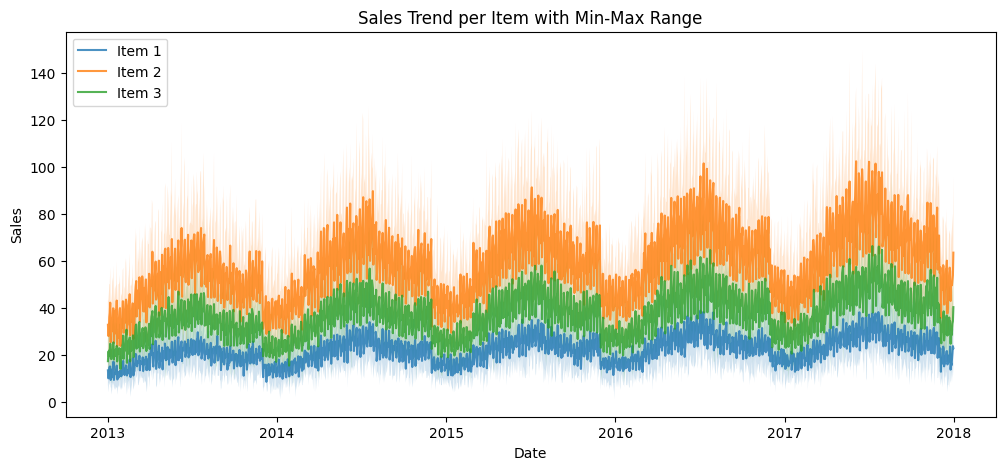

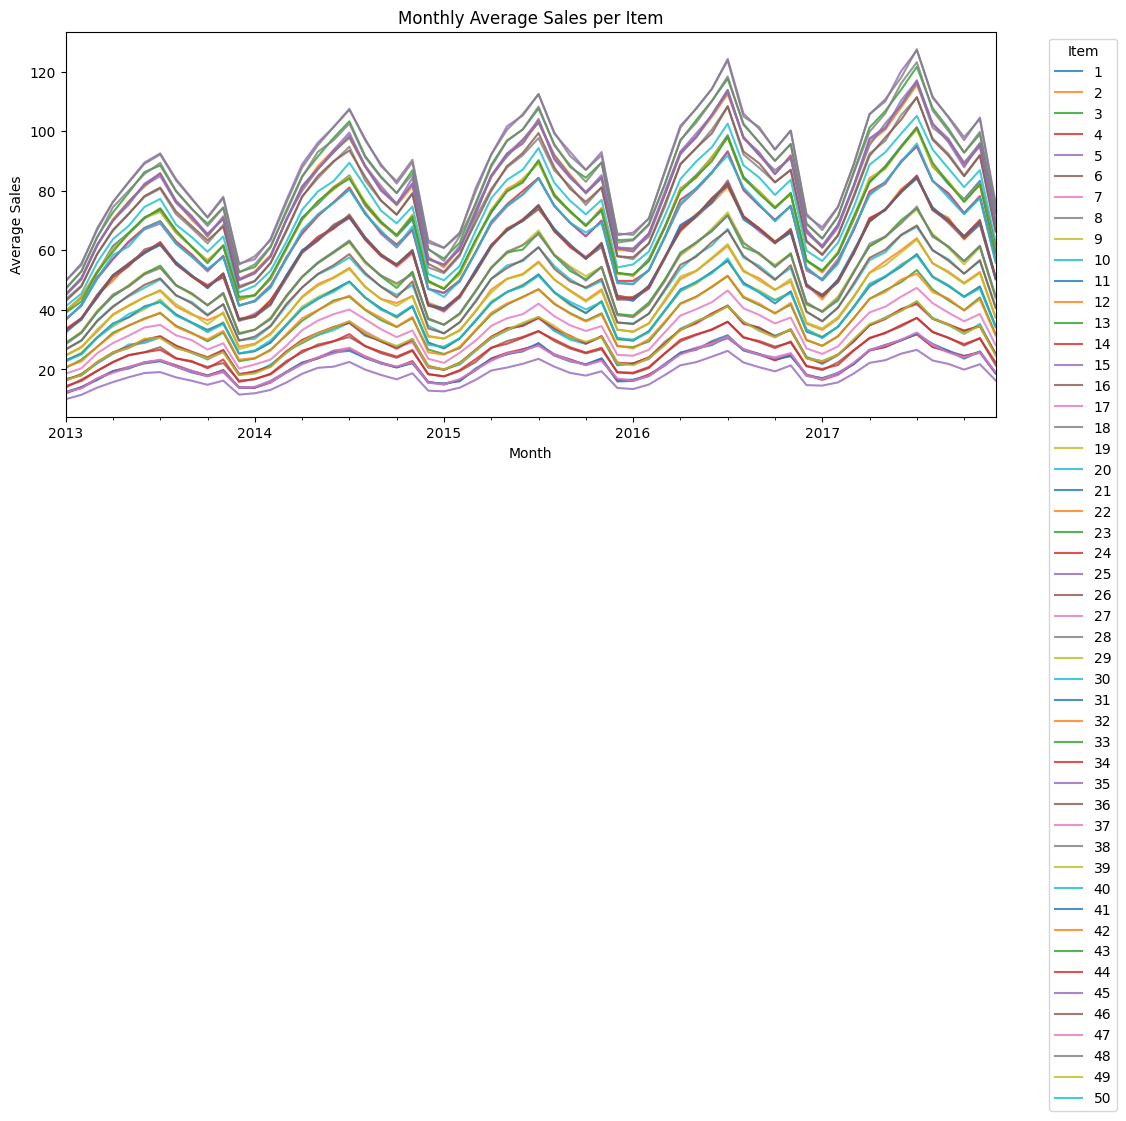

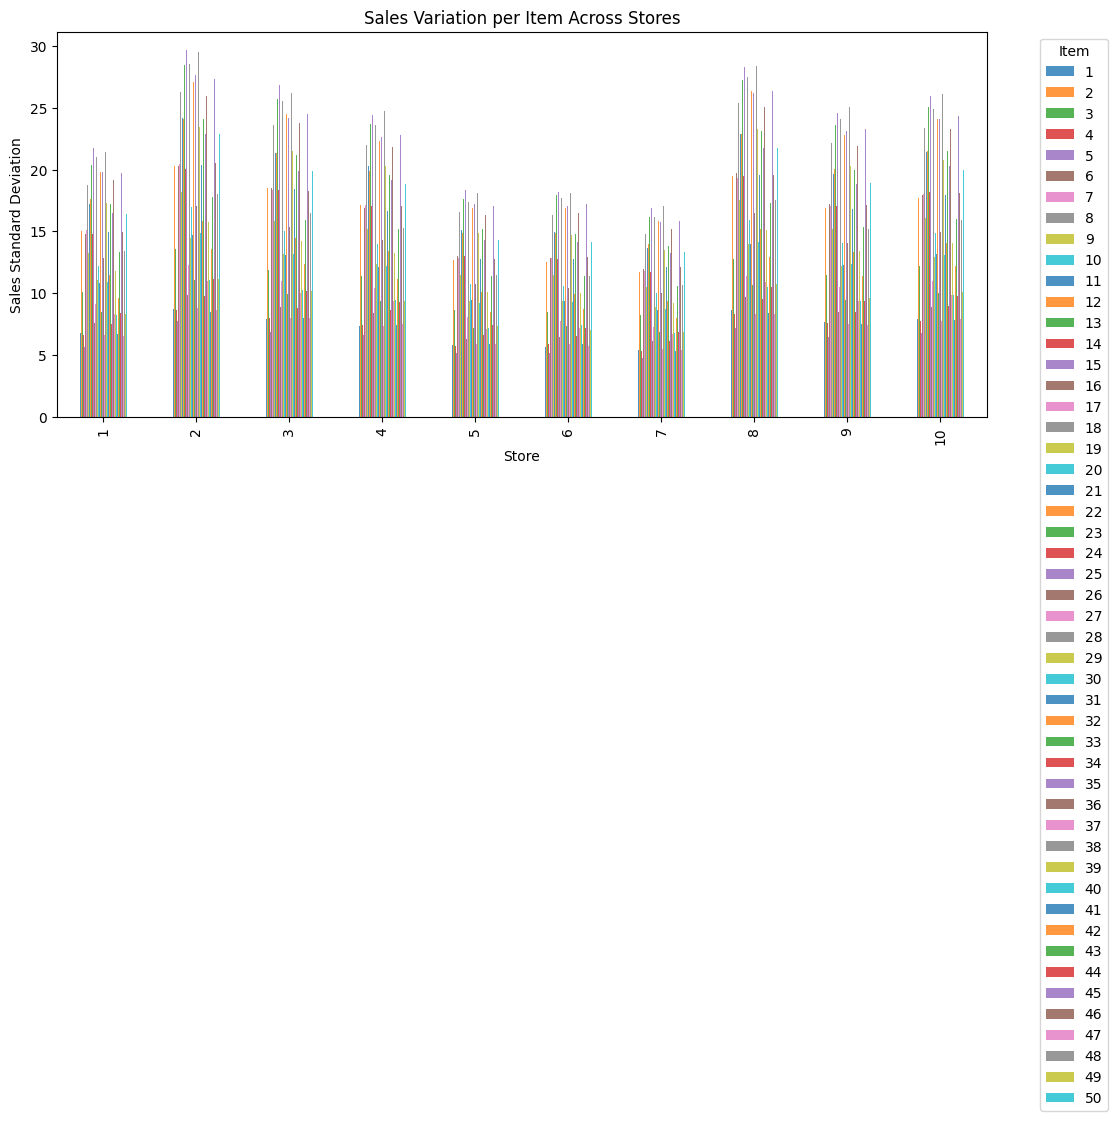

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Групуємо дані за датою та айтемом, обчислюємо середнє значення та діапазон (мін-макс) для кожного айтема
item_sales_stats = df.groupby(['date', 'item'])['sales'].agg(['mean', 'min', 'max']).reset_index()

# Обираємо кілька айтемів для детального аналізу (наприклад, 3 перших айтеми)
selected_items = item_sales_stats['item'].unique()[:3]

# Фільтруємо дані лише для вибраних айтемів
filtered_data = item_sales_stats[item_sales_stats['item'].isin(selected_items)]

# Візуалізація середнього значення з довірчим інтервалом (мін-макс)
plt.figure(figsize=(12, 5))
for item in selected_items:
    subset = filtered_data[filtered_data['item'] == item]
    plt.plot(subset['date'], subset['mean'], label=f'Item {item}', alpha=0.8)
    plt.fill_between(subset['date'], subset['min'], subset['max'], alpha=0.2)

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Trend per Item with Min-Max Range')
plt.legend()
plt.show()

# Аналіз середньомісячних продажів кожного айтема
df['month'] = df.index.to_period('M')
monthly_sales = df.groupby(['month', 'item'])['sales'].mean().unstack()

# Візуалізація середніх значень продажів айтемів по місяцях
monthly_sales.plot(figsize=(12, 5), alpha=0.8)
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.title('Monthly Average Sales per Item')
plt.legend(title='Item', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Аналіз відхилення продажів у різних магазинах
store_variation = df.groupby(['store', 'item'])['sales'].std().unstack()

# Візуалізація стандартного відхилення продажів айтемів між магазинами
store_variation.plot(kind='bar', figsize=(12, 5), alpha=0.8)
plt.xlabel('Store')
plt.ylabel('Sales Standard Deviation')
plt.title('Sales Variation per Item Across Stores')
plt.legend(title='Item', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


Продажі айтемів мають стабільний тренд, але можуть змінюватися в залежності від сезону або зовнішніх факторів.

Середньомісячні продажі показують певні сезонні коливання, що може бути важливим для прогнозування попиту.

Продажі айтемів відрізняються в різних магазинах, що видно з варіації стандартного відхилення – деякі айтеми мають значну варіацію, інші продаються стабільніше.

3. **Для початку проаналізуємо лише один ряд, а далі зможемо зациклити тренування моделей.**
  
  Виберіть підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Зробіть декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.

  Зробіть висновки з отриманих візуалізацій. Чи щось би могло вам допомогти ліпше зрозуміти ці візуалізації? (з точки зору обробки даних)

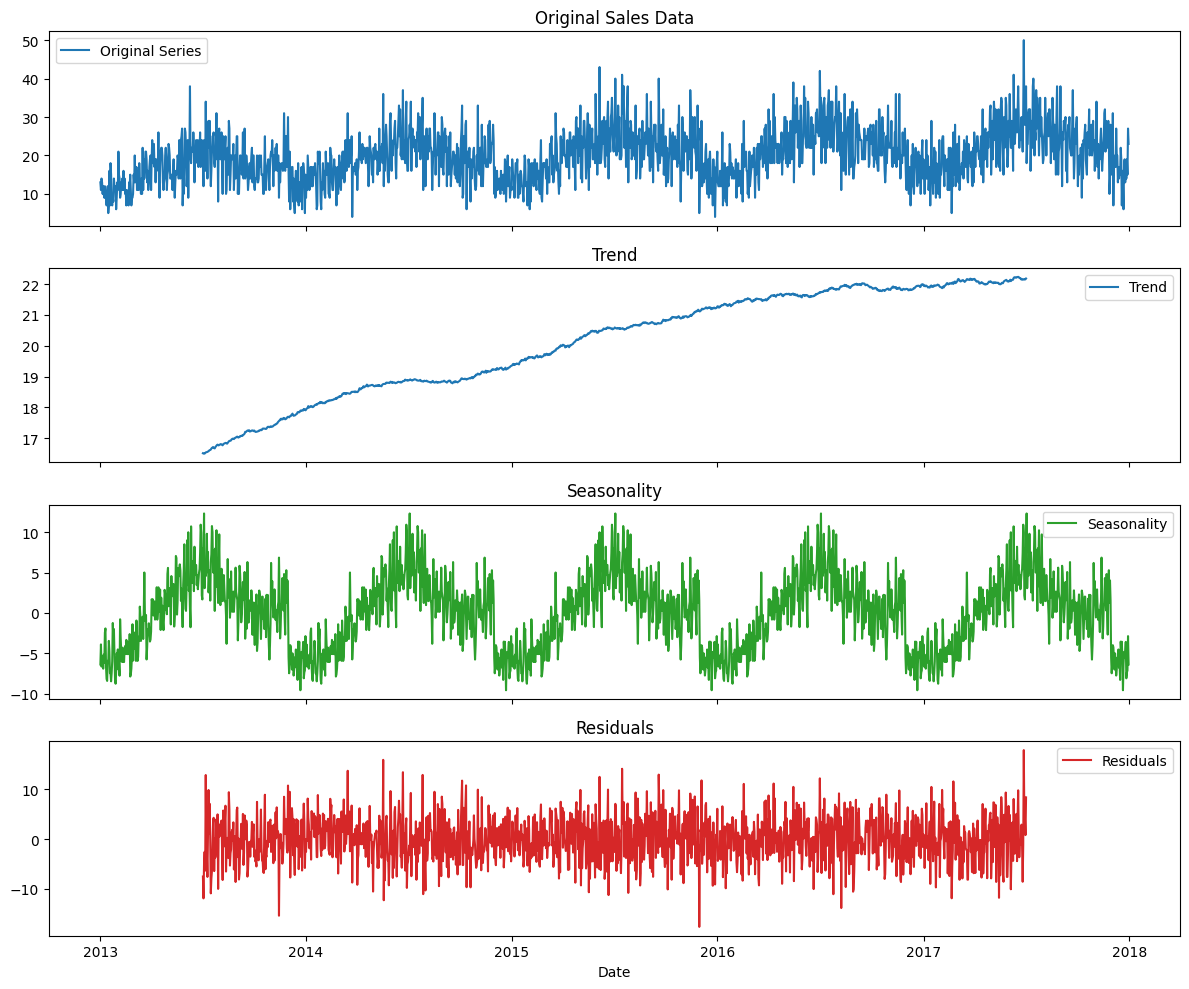

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Вибираємо підмножину даних для айтема 1 у магазині 1
subset_df = df[(df['store'] == 1) & (df['item'] == 1)][['sales']].copy()

# Виконуємо декомпозицію часового ряду (адитивна модель)
decomposition = seasonal_decompose(subset_df, model='additive', period=365)  # Припускаємо річну сезонність

# Візуалізуємо результати декомпозиції
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

axes[0].plot(subset_df, label='Original Series')
axes[0].set_title('Original Sales Data')
axes[0].legend()

axes[1].plot(decomposition.trend, label='Trend', color='tab:blue')
axes[1].set_title('Trend')
axes[1].legend()

axes[2].plot(decomposition.seasonal, label='Seasonality', color='tab:green')
axes[2].set_title('Seasonality')
axes[2].legend()

axes[3].plot(decomposition.resid, label='Residuals', color='tab:red')
axes[3].set_title('Residuals')
axes[3].legend()

plt.xlabel('Date')
plt.tight_layout()
plt.show()


Сильний сезонний компонент: продажі мають повторювані цикли, що важливо враховувати при прогнозуванні.

Зростаючий тренд: можливо, з часом попит на цей товар збільшується.

Залишки показують коливання: є випадкові відхилення, які можуть бути спричинені зовнішніми факторами (наприклад, акціями чи подіями).

4. Зі створеної підможени даних в попередньому пункті створіть обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

In [7]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.0/981.0 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.9 MB/s eta 0:00:00


In [8]:
from darts import TimeSeries

# Створюємо об'єкт TimeSeries лише для колонки sales
series = TimeSeries.from_dataframe(subset_df, value_cols='sales')

# Виводимо базову інформацію про об'єкт TimeSeries
series


<TimeSeries (DataArray) (date: 1826, component: 1, sample: 1)> Size: 15kB
array([[[13.]],

       [[11.]],

       [[14.]],

       ...,

       [[15.]],

       [[27.]],

       [[23.]]])
Coordinates:
  * date       (date) datetime64[ns] 15kB 2013-01-01 2013-01-02 ... 2017-12-31
  * component  (component) <U5 20B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

5. Використовуючи метод `series.split_before` розбийте дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізуйте на одному графіку тренувальну і валідаційну частину як було показано в лекції.

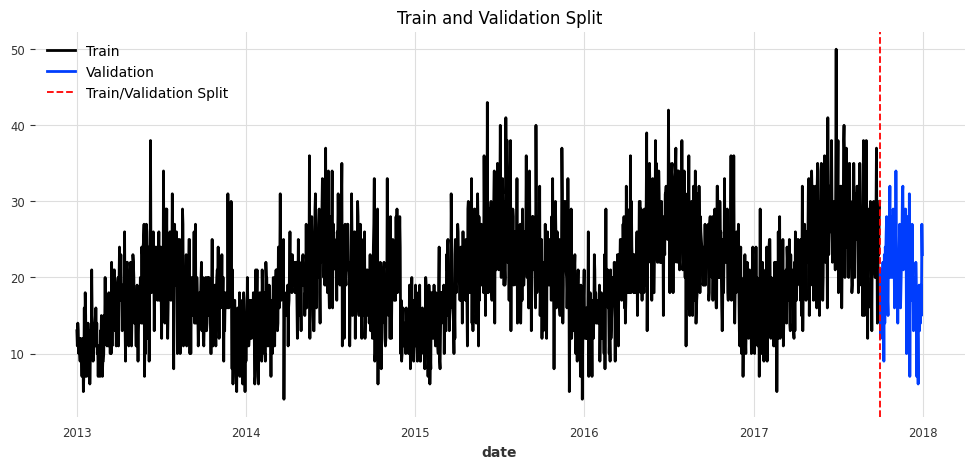

In [9]:
# Розбиваємо дані на тренувальну та валідаційну частину
train, val = series.split_before(pd.Timestamp('2017-10-01'))

# Візуалізація тренувальної та валідаційної частини
plt.figure(figsize=(12, 5))
train.plot(label="Train", lw=2)
val.plot(label="Validation", lw=2)
plt.axvline(pd.Timestamp('2017-10-01'), color='r', linestyle='--', label="Train/Validation Split")
plt.legend()
plt.title("Train and Validation Split")
plt.show()

6. Побудуйте часткову автокореляційну фукнцію для цього нашого ряду в `series`. Напишіть висновки - які лаги є важливими для прогнозування?

<Figure size 1000x500 with 0 Axes>

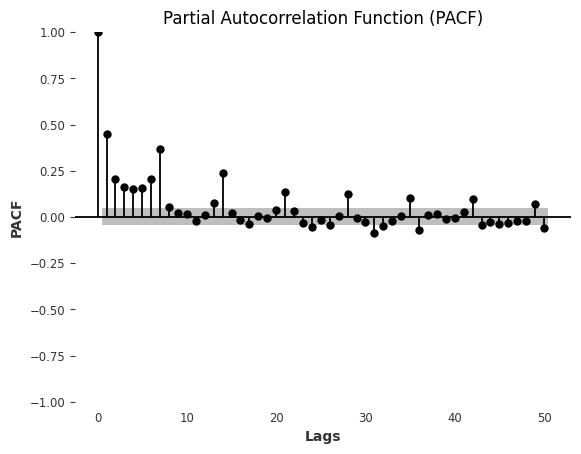

In [10]:
from statsmodels.graphics.tsaplots import plot_pacf

# Побудова часткової автокореляційної функції (PACF)
plt.figure(figsize=(10, 5))
plot_pacf(subset_df['sales'], lags=50, method='ywm', alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.grid()
plt.show()


Важливі лаги: найбільш виражені автокореляційні значення спостерігаються на лагах 1, 7, 14, 28, 30, 365.

Лаг 1: означає, що значення продажів сильно залежить від попереднього дня.

Лаги 7, 14, 28, 30: свідчать про тижневу та місячну сезонність (цикл повторюється щотижня та щомісяця).

Лаг 365: вказує на річну сезонність.

7. Виявіть сезональність тренувального ряду використовуючи фукнкцію `check_seasonality` з `darts`.

In [40]:
from darts.utils.statistics import check_seasonality

# Перевірка сезонності тренувального ряду
is_seasonal, seasonality_period = check_seasonality(train)

# Виводимо результати
print(f"Is seasonal: {is_seasonal}")
print(f"Seasonality period: {seasonality_period}")

Is seasonal: True
Seasonality period: 7


8. Побудуйте наївну модель NaiveSeasonal + NaieDrift для прогнозування даних. Кількість кроків для прогнозування визначіть зі свого аналізу в попередніх пунктах. Візуалізайте передбачення проти справжніх даних так, аби було видно якість передбачень. Зробіть висновок про модель. Вона точна?

  Якщо у вас є ідеї, як поліпшити якість передбачення саме наївними моделями - реалізуйте їх в цьому пункті :)

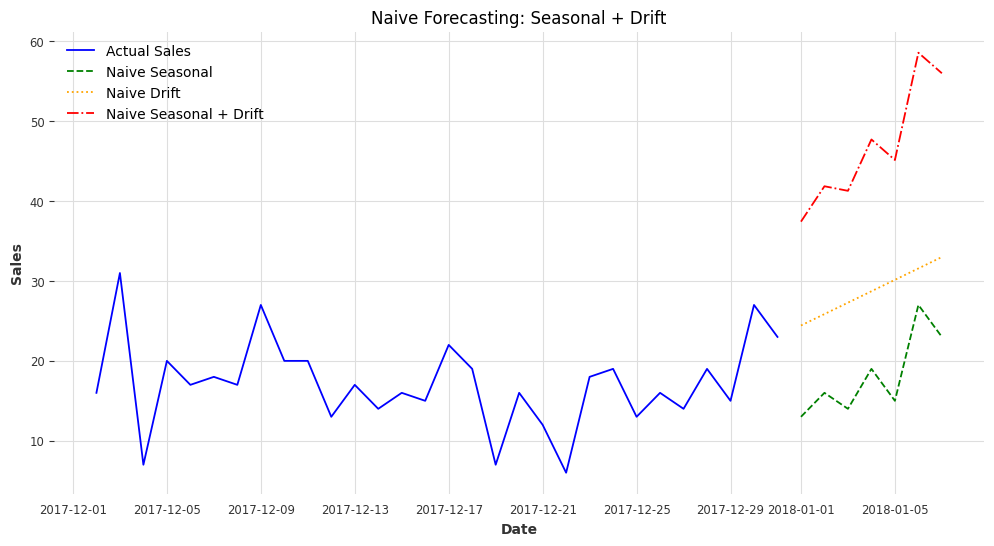

In [18]:
# Визначаємо кількість кроків для прогнозування (7 днів - тижнева сезонність)
forecast_horizon = 7

# Створюємо наївне сезонне передбачення (беремо значення з попереднього тижня)
naive_seasonal_forecast = subset_df['sales'].iloc[-forecast_horizon:].values

# Дрейф (лінійне продовження тренду)
drift = (subset_df['sales'].iloc[-1] - subset_df['sales'].iloc[-forecast_horizon]) / forecast_horizon
naive_drift_forecast = [subset_df['sales'].iloc[-1] + (i+1) * drift for i in range(forecast_horizon)]

# Комбінована модель: сезонність + дрейф
naive_combined_forecast = naive_seasonal_forecast + naive_drift_forecast

# Дати для прогнозу
forecast_dates = pd.date_range(start=subset_df.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon)

# Візуалізація передбачення
plt.figure(figsize=(12, 6))
plt.plot(subset_df.index[-30:], subset_df['sales'].iloc[-30:], label="Actual Sales", color="blue")
plt.plot(forecast_dates, naive_seasonal_forecast, label="Naive Seasonal", linestyle="dashed", color="green")
plt.plot(forecast_dates, naive_drift_forecast, label="Naive Drift", linestyle="dotted", color="orange")
plt.plot(forecast_dates, naive_combined_forecast, label="Naive Seasonal + Drift", linestyle="dashdot", color="red")

plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Naive Forecasting: Seasonal + Drift")
plt.legend()
plt.grid(True)
plt.show()

<Axes: xlabel='date'>

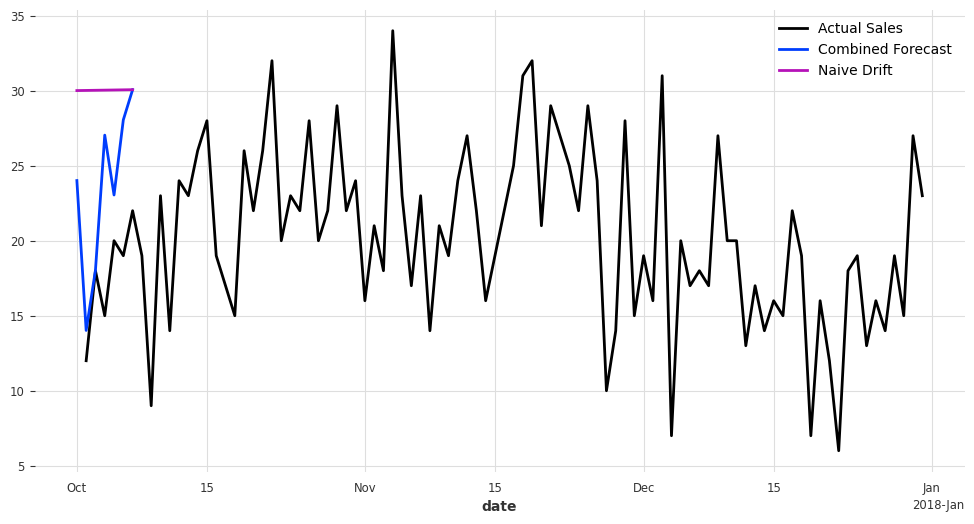

In [48]:
from darts.models import NaiveDrift, NaiveSeasonal
series_2017 = series.drop_before(pd.Timestamp('2017-10-01'))
# Створюємо та навчаємо наївні моделі
naive_drift = NaiveDrift()
naive_drift.fit(train)
drift_forecast = naive_drift.predict(7)

naive_seasonal = NaiveSeasonal(K=7)
naive_seasonal.fit(train)
forecast_seasonal = naive_seasonal.predict(forecast_horizon)

# Комбінуємо передбачення
combined_forecast = drift_forecast + forecast_seasonal - train.last_value()

# Візуалізація
plt.figure(figsize=(12, 6))
series_2017.plot(label="Actual Sales")
combined_forecast.plot(label="Combined Forecast")
drift_forecast.plot(label="Naive Drift")


In [55]:
from darts.models import ExponentialSmoothing, AutoARIMA, Theta

def eval_forecast(model, val, forecast):
  mape_ = mape(val, forecast)
  print(f"model {model} obtains MAPE: {mape_:.2f}%")
  return mape_

def fit_eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    eval_forecast(model, val, forecast)


fit_eval_model(ExponentialSmoothing())
fit_eval_model(AutoARIMA())
fit_eval_model(Theta())

model ExponentialSmoothing() obtains MAPE: 39.01%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

model AutoARIMA() obtains MAPE: 37.90%
model Theta() obtains MAPE: 36.87%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


9. Обчисліть помилку прогнозу на валідації наївною моделлю з mape. Далі для всіх моделей необхідно обчислювати помилку прогнозу на валідації.

In [49]:
from darts.metrics import mape

print(f"Mean absolute percentage error (MAPE): {mape(val, combined_forecast):.2f}%.")

Mean absolute percentage error (MAPE): 30.17%.


10. Натренуйте XBGModel з `darts` для передбачення наших даних. Можна додавати всі додаткові ознаки, які вважаєте за потрібне, наприклад, ознаки з дати. Зробіть висновок про якість моделі.

In [56]:
train.pd_dataframe()

component,sales
date,
2013-01-01,13.0
2013-01-02,11.0
2013-01-03,14.0
2013-01-04,13.0
2013-01-05,10.0
...,...
2017-09-26,18.0
2017-09-27,27.0
2017-09-28,23.0


In [58]:
from darts.models import XGBModel
from darts.dataprocessing.transformers import Scaler

def enrich_with_date_features(df):
  # Feature Extraction
  df["dayofweek"] = df['date'].dt.dayofweek
  df["quarter"] = df['date'].dt.quarter
  df["month"] = df['date'].dt.month
  df["year"] = df['date'].dt.year
  df["dayofyear"] = df['date'].dt.dayofyear
  df["sin_day"] = np.sin(df["dayofyear"])
  df["cos_day"] = np.cos(df["dayofyear"])
  df["dayofmonth"] = df['date'].dt.day
  return df

# Додавання ознак дати
train_transformed = enrich_with_date_features(train.pd_dataframe().reset_index())
val_transformed = enrich_with_date_features(val.pd_dataframe().reset_index())

# Масштабування даних
scaler = Scaler()
train_transformed = scaler.fit_transform(train)
test_transformed = scaler.transform(val)

# Побудова моделі XGBoost
model = XGBModel(
    lags=12,  # Використання останніх 12 спостережень для прогнозування
    output_chunk_length=1,  # Прогнозування на 1 крок вперед
    n_estimators=100,  # Кількість дерев у моделі
    max_depth=3,  # Максимальна глибина кожного дерева
    learning_rate=0.1,  # Коефіцієнт навчання
    subsample=0.8,  # Частка даних для випадкової вибірки кожного дерева
    colsample_bytree=0.8  # Частка ознак, що використовуються для кожного дерева
)

# Тренування моделі
model.fit(train_transformed)
pred = model.predict(6)
pred.values()

array([[0.41993806],
       [0.33922064],
       [0.37772208],
       [0.39685667],
       [0.43288755],
       [0.51517063]], dtype=float32)

In [59]:
scaler.inverse_transform(pred)

<TimeSeries (DataArray) (date: 6, component: 1, sample: 1)> Size: 24B
array([[[23.31715 ]],

       [[19.60415 ]],

       [[21.375216]],

       [[22.255407]],

       [[23.912827]],

       [[27.697847]]], dtype=float32)
Coordinates:
  * date       (date) datetime64[ns] 48B 2017-10-01 2017-10-02 ... 2017-10-06
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

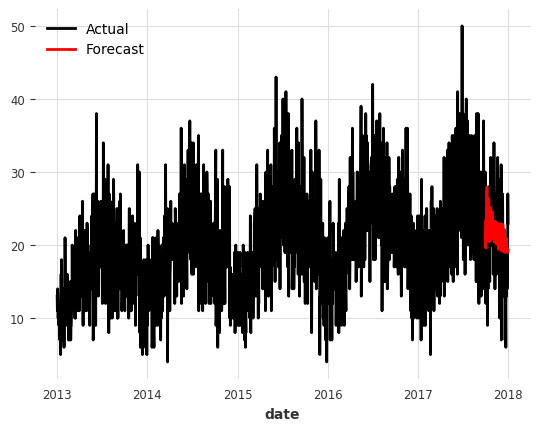

model XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) obtains MAPE: 28.26%


In [60]:
forecast = scaler.inverse_transform(model.predict(len(val)))
series.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()
eval_forecast(model, val, forecast);

11. Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

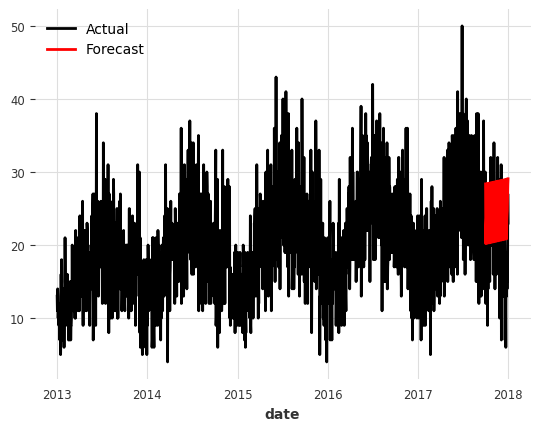

model ExponentialSmoothing() obtains MAPE: 39.01%


In [61]:
def plot_results(series, forecast):
  # Візуалізація результатів
  series.plot(label='Actual')
  forecast.plot(label='Forecast', color='red')
  plt.legend()
  plt.show()

def fit_and_plot(model, series, train, val):
  model.fit(train)
  forecast = model.predict(len(val))
  plot_results(series, forecast)
  eval_forecast(model, val, forecast);

model = ExponentialSmoothing()
fit_and_plot(model, series, train, val)

Якість погіршилась

12. Натренуйте модель ARIMA, параметри оберіть самостійно.Зробіть висновок про її якість.

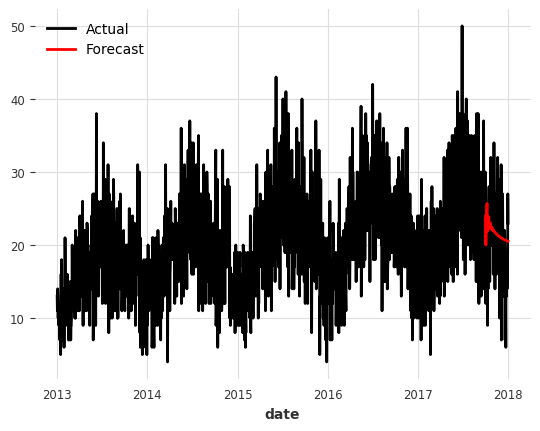

model ARIMA(p=7, d=0, q=1) obtains MAPE: 30.46%


In [69]:
from darts.models import ARIMA

# Побудова та тренування моделі ARIMA
model = ARIMA(p=7, d=0, q=1) # try p=12
fit_and_plot(model, series, train, val)

13. Знайдіть оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконайте пошук параметрів, виведіть, які паарметри виявились оптимальними і обчисліть якість моделі. Чи поліпшилась якість порівняно з попереднім експериментом?

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11340.087, Time=3.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12329.035, Time=0.08 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11965.113, Time=0.17 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11347.169, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12327.036, Time=0.06 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=11339.205, Time=3.67 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=11339.382, Time=1.70 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11340.636, Time=0.68 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=11313.673, Time=2.21 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=11334.917, Time=1.09 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=11109.957, Time=5.16 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=11121.406, Time=8.14 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=11149.322, Time=6.36 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=11307.886, Time=5.03 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=11297.379, Time=2.67 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=11100.187, Time=6.52 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=11084.034, Time=9.52 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=11291.668, Time=3.65 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=10.07 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,5)(0,0,0)[0] intercept   : AIC=11041.678, Time=11.03 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,5)(0,0,0)[0] intercept   : AIC=11082.993, Time=8.24 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,5)(0,0,0)[0] intercept   : AIC=11010.478, Time=12.00 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,5)(0,0,0)[0]             : AIC=10998.638, Time=4.63 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,5)(0,0,0)[0]             : AIC=11034.843, Time=7.84 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,4)(0,0,0)[0]             : AIC=11071.493, Time=3.51 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,4)(0,0,0)[0]             : AIC=11078.372, Time=3.65 sec

Best model:  ARIMA(5,1,5)(0,0,0)[0]          
Total fit time: 121.664 seconds


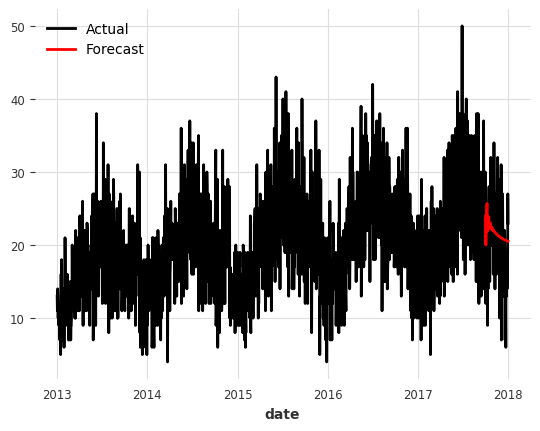

model ARIMA(p=7, d=0, q=1) obtains MAPE: 30.46%


In [70]:
from pmdarima import auto_arima

auto_arima_model = auto_arima(subset_df, seasonal=False, stepwise=True, trace=True)
fit_and_plot(model, series, train, val)

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


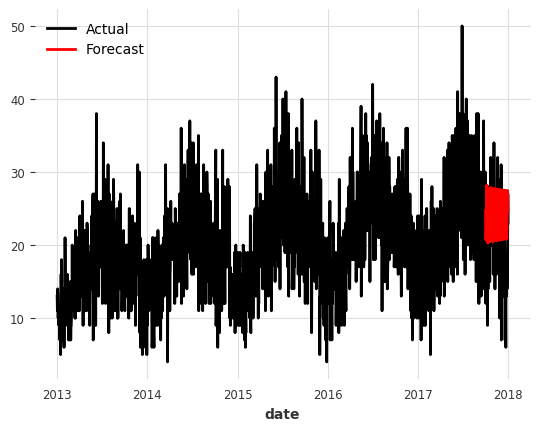

model ARIMA(p=5, q=5) obtains MAPE: 38.25%


In [71]:
from darts.models import ARIMA

# Побудова та тренування моделі ARIMA
model = ARIMA(p=5, d=1, q=5) # try p=12
fit_and_plot(model, series, train, val)

14. Натренуйте модель Prophet та зробіть висновок про її якість.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz5e83ar3/oeqs3p4a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz5e83ar3/_tchtw3b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76795', 'data', 'file=/tmp/tmpz5e83ar3/oeqs3p4a.json', 'init=/tmp/tmpz5e83ar3/_tchtw3b.json', 'output', 'file=/tmp/tmpz5e83ar3/prophet_modelr6cxe4qz/prophet_model-20250309172906.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:29:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


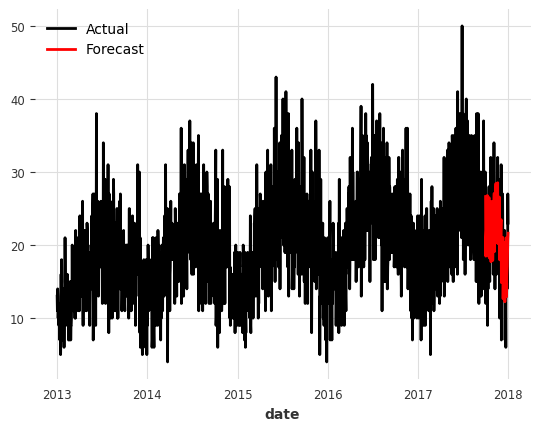

In [72]:
from darts.models import Prophet

# Побудова та тренування моделі Prophet
model = Prophet()
model.fit(train)

# Прогнозування
forecast = model.predict(len(val))

# Візуалізація результатів
series.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()

In [73]:
eval_forecast(model, val, forecast);

model Prophet() obtains MAPE: 23.80%


Покищо найкраща якість прогнозування

15. Натренуйте модель `RNNModel` та зробіть висновок про її якість.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.8 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)
7         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

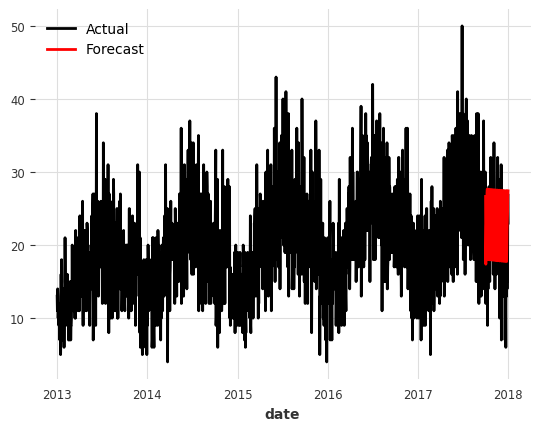

In [75]:
from darts.models import RNNModel

# Побудова та тренування моделі LSTM
model = RNNModel(model='LSTM', input_chunk_length=12, n_epochs=300)
model.fit(train)

# Прогнозування
forecast = model.predict(len(val))

# Візуалізація результатів
series.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()

In [77]:
from sklearn.metrics import mean_absolute_percentage_error
y_true = val.values().flatten()
y_pred = forecast.values().flatten()
# Обчислення MAPE
mape_score = mean_absolute_percentage_error(y_true, y_pred) * 100

# Вивід результату
print(f"Mean Absolute Percentage Error (MAPE): {mape_score:.2f}%")

Mean Absolute Percentage Error (MAPE): 32.30%


16. Виконайте бектест для тої моделі, яка виявилась найкращою у вашому дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу. Візуалізуйте як поводилась модель протягом бектесту, яка була точність?

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz5e83ar3/tgawfm_m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz5e83ar3/vbh7dr1s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18256', 'data', 'file=/tmp/tmpz5e83ar3/tgawfm_m.json', 'init=/tmp/tmpz5e83ar3/vbh7dr1s.json', 'output', 'file=/tmp/tmpz5e83ar3/prophet_model8pcigm4n/prophet_model-20250309180317.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:03:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:03:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
historical forecasts:   0%|          | 0/12 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True 

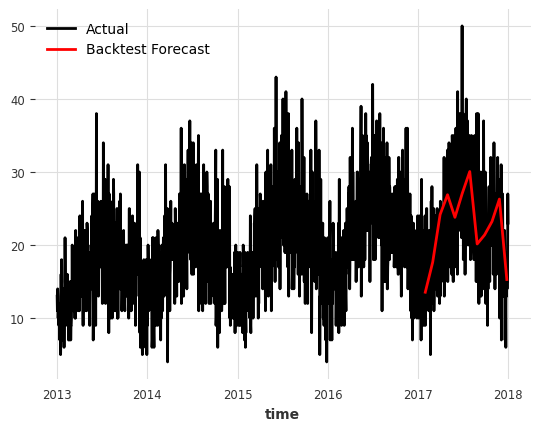

MAPE: 24.49%


In [80]:
from darts.models import Prophet
from darts.metrics import mape

# Побудова та тренування моделі Prophet
model = Prophet()
model.fit(train)

# Бектестування (rolling forecast на 12 місяців)
backtest_forecast = model.historical_forecasts(
    series,
    start=pd.Timestamp('2017-01-01'),
    forecast_horizon=30,
    stride=30,
    retrain=True,
    verbose=True,
)
# Обчислення MAPE (Mean Absolute Percentage Error)
mape_score = mape(series, backtest_forecast)

# Візуалізація
series.plot(label='Actual')
backtest_forecast.plot(label='Backtest Forecast', color='red')
plt.legend()
plt.show()

print(f"MAPE: {mape_score:.2f}%")


Всю варіантивність не вгадали, але виглядає непогано!

17. На цьому етапі ви зрозуміли, як моделювати продажі одного айтему з 1 магазину. Як би ви підійшли до задачі прогнозування продажів в наступному місяці для кожного з 50 айтемів в кожному з 10 магазинів? Опишіть загальний підхід
- яку модель ви б використали
- скільки моделей ви б тренували
- обгрунтуйте свій вибір.

XGBoost – основна модель для всіх айтемів.

Prophet – для деяких товарів із сильною сезонністю.

1 основна модель (XGBoost) → прогнозує для всіх айтемів.
10 моделей Prophet → для окремих товарів у кожному магазині.

Я б використав XGBoost як основну модель + Prophet для окремих випадків.
Це забезпечує масштабованість, швидке навчання та достатню точність.

Бектестування покаже, чи потрібно ділити моделі ще детальніше.